# The SRCNN Network


```
let's start
```
<img src="https://miro.medium.com/max/875/1*mZJO-i6ImYyXHorv4H1q_Q.png">


## 1. Importing Packages


In [ ]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# displays pyplot figures in the notebook
%matplotlib inline

## 2. Image Quality Metrics
let's define a couple of functions that we can use to calculate the **PSNR**, **MSE**, and SSIM. The structural similarity (SSIM) index was imported directly from the scikit-image library; however, we will have to define our own functions for the PSNR and MSE. Furthermore, we will wrap all three of these metrics into a single function that we can call later.

In [ ]:
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.0))
    return 20 * math.log10(255.0 / rmse)

# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores

## 3. Preparing Images
### Downgrading Images

we have some images, we want to produce low-resolution versions of these same images. We can accomplish this by resizing the images, both downwards and upwards, using OpeCV. There are several interpolation methods that can be used to resize images; however, we will be using bilinear interpolation.

Once we produce these low-resolution images, we can save them in a new folder.

In [ ]:
# prepare degraded images by introducing quality distortions via resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = h / factor
        new_width = w / factor
        
        # resize the image - down
        img = cv2.resize(img, (int(new_width), int(new_height)), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)
prepare_images('source/', 2)

Saving woman_GT.bmp
Saving flowers.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving foreman.bmp
Saving barbara.bmp
Saving monarch.bmp
Saving man.bmp
Saving ppt3.bmp
Saving lenna.bmp
Saving zebra.bmp
Saving baby_GT.bmp
Saving face.bmp
Saving bridge.bmp
Saving head_GT.bmp
Saving pepper.bmp
Saving baboon.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp


## 3. Testing Low-Resolution Images

To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded, let's calculate the PSNR, MSE, and SSIM between our reference images and the degraded images that we just prepared.

In [ ]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

woman_GT.bmp
PSNR: 29.326236280817465
MSE: 227.812729498164
SSIM: 0.9335397280466592

flowers.bmp
PSNR: 27.454504805386144
MSE: 350.55093922651935
SSIM: 0.8697286286974628



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

monarch.bmp
PSNR: 30.196242365288896
MSE: 186.45643615722656
SSIM: 0.9439574293434104

man.bmp
PSNR: 27.22646369798821
MSE: 369.4496383666992
SSIM: 0.8214950645456561

ppt3.bmp
PSNR: 24.84926168950471
MSE: 638.6684263912582
SSIM: 0.9284023942315316

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.94800567626953
SSIM: 0.8460989200521499

zebra.bmp
PSNR: 27.909840639329513
MSE: 315.6585459528818
SSIM: 0.8911656209329116

baby_GT.bmp
PSNR: 34.371806409661986
MSE: 71.28874588012695
SSIM: 0.9356987872724932

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

bridge.bmp
PSNR: 25.850528790115554
MSE: 507.1643714904785
SSIM: 0.78

## 4. Building the SRCNN Model
Now that we have our low-resolution images and all three image quality metrics functioning properly, we can start building the SRCNN. In Keras, it’s as simple as adding layers one after the other. The architecture and hyperparameters of the SRCNN network can be obtained from the publication referenced above.

In [ ]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

## 5. Deploying the SRCNN
Now that we have defined our model, we can use it for single-image super-resolution. However, before we do this, we will need to define a couple of image processing functions. Furthermore, it will be necessary to preprocess the images extensively before using them as inputs to the network. This processing will include cropping and color space conversions.
Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN. These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras
Once we have tested our network, we can perform single-image super-resolution on all of our input images. Furthermore, after processing, we can calculate the PSNR, MSE, and SSIM on the images that we produce. We can save these images directly or create subplots to conveniently display the original, low-resolution, and high-resolution images side by side.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.660201098201455
MSE: 210.95095982936368
SSIM: 0.8989099943658779



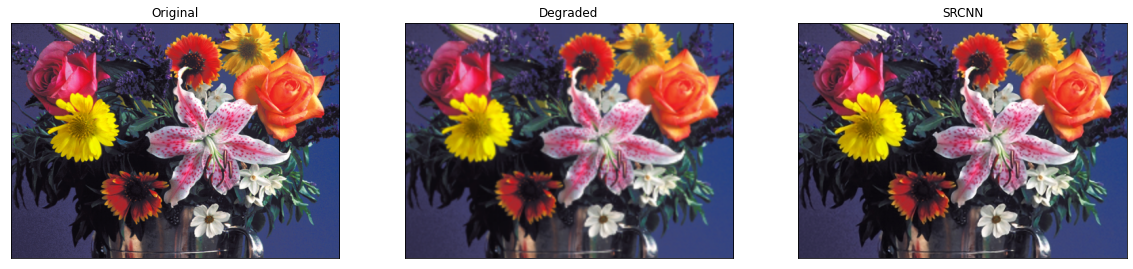

In [ ]:
# define necessary image processing functions

def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img
# define main prediction function

def predict(image_path):
    
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores
ref, degraded, output, scores = predict('images/flowers.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


Saving woman_GT.bmp
Saving flowers.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving foreman.bmp
Saving barbara.bmp
Saving monarch.bmp
Saving man.bmp
Saving ppt3.bmp
Saving lenna.bmp
Saving zebra.bmp
Saving baby_GT.bmp
Saving face.bmp
Saving bridge.bmp
Saving head_GT.bmp
Saving pepper.bmp
Saving baboon.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
